In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
os.chdir('/content/drive/MyDrive/BADM550/')
dataset_path = 'criteo_attribution_dataset/criteo_attribution_dataset.tsv.gz'

In [3]:
DEBUG_SAMPLE = 0.8

In [4]:
def get_sampled_dataset(debug_sample=0.7):
# Get a dataset in which we sample on user ids to ensure we keep the entire histories
  df = pd.read_csv(dataset_path, sep='\t', compression="gzip")
  uid_and_salt = df['uid'].astype(str) + 'hash_salt_for_sampling'
  hashed_uid_and_salt = pd.util.hash_pandas_object(uid_and_salt, index=False)
  random_column_based_on_uid = hashed_uid_and_salt / np.iinfo(np.uint64).max
  return df[random_column_based_on_uid < debug_sample]

df_criteo = get_sampled_dataset(DEBUG_SAMPLE)
df_criteo.shape

(13170080, 22)

In [5]:
df_criteo.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072
5,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,262565,30763035,9068207,9107790,29196072,32440044,1973606,2687461,29841067,21091108


In [6]:
num_distinct_campaigns = df_criteo['campaign'].nunique()
print("Number of distinct campaigns:", num_distinct_campaigns)

Number of distinct campaigns: 675


In [7]:
from sklearn.preprocessing import MinMaxScaler
#Creating a JourneylD column from UserlD and ConversionlD
def add_derived_columns(df):
  df_ext = df.copy()
  df_ext ['jid'] = df_ext['uid'].map(str) +'_'+ df_ext['conversion_id'].map(str)
  min_max_scaler = MinMaxScaler()
  for cname in ('timestamp','time_since_last_click'):
    x = df_ext[cname].values.reshape(-1,1)
    df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
  return df_ext

df_criteo = add_derived_columns(df_criteo)

In [8]:
np.random.seed(42)
n_campaigns = 400

def sample_campaigns(df,n_campaigns):
  campaigns = np.random.choice(df_criteo['campaign'].unique(),n_campaigns,replace=False)
  return df[df['campaign'].isin(campaigns)]

#Calling the sample_campaigns function with n_campaigns=400
df_criteo = sample_campaigns(df_criteo,n_campaigns)
df_criteo.shape

(8456216, 25)

In [9]:
def filter_journeys_by_length(df,min_touchpoints) :
  if min_touchpoints <= 1:
    return df
  else :
    grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
    return df[df['jid'].isin(grouped[grouped['count'] >= min_touchpoints] ['jid'].values)]

#Calling the filter journeys_by_length function
df_criteo = filter_journeys_by_length(df_criteo, 2)
#Displaying the structure of the datasetd

def balance_conversions(df):
  df_minority = df [df.conversion == 1]
  df_majority = df [df.conversion == 0]
  df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0])
  df_majority_sampled = pd.DataFrame(data=None, columns=df. columns)
  for jid_chunk in df_majority_jids:
    df_majority_sampled = pd. concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
    if df_majority_sampled.shape[0] > df_minority.shape [0]:
      break
    return pd.concat([df_majority_sampled,df_minority]).sample(frac=1).reset_index(drop=True)

df_criteo = balance_conversions(df_criteo)

<ipython-input-9-1a9e44ce47fb>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_majority_sampled = pd. concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])


In [10]:
df_criteo.shape

(286552, 25)

In [11]:
def map_one_hot(df, column_names, result_column_name):
  mapper = {}
  for i, col_name in enumerate(column_names):
    for val in df[col_name].unique():
      mapper[str(val) + str(i)] = len(mapper)

  df_ext = df.copy()

  def one_hot (values):
    v = np.zeros(len(mapper))
    for i, val in enumerate(values):
      v[mapper[str(val) + str(i)]] = 1
    return v

  df_ext[result_column_name] = df_ext[column_names].values.tolist()
  df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
  return df_ext

df_criteo = map_one_hot(df_criteo, ['cat1','cat2','cat3','cat4','cat5','cat6','cat8'], 'cats')
df_criteo.cats[0]

array([1., 0., 0., ..., 0., 0., 0.])

In [13]:
df_criteo = map_one_hot(df_criteo,['campaign'],'campaigns').sort_values(by=['timestamp_norm'])
df_criteo.shape

(286552, 27)

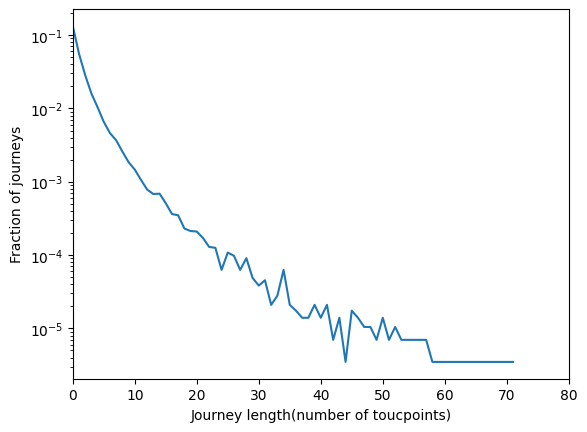

In [15]:
import matplotlib.pyplot as plt
def journey_length_histogram(df):
  counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
  return counts.index, counts. values / df.shape[0]

hist_x,hist_y= journey_length_histogram(df_criteo)

plt.plot (range(len(hist_x)),hist_y,label = 'all journeys')
plt.yscale('log')
plt.xlim (0, 80)
plt.xlabel('Journey length(number of toucpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

# Markov Chain Attribution model

In [17]:
import numpy as np
import pandas as pd

def create_transition_matrix(df, column='campaign'):
    unique_campaigns = df[column].unique()
    n_campaigns = len(unique_campaigns)
    transition_matrix = pd.DataFrame(np.zeros((n_campaigns, n_campaigns)), index=unique_campaigns, columns=unique_campaigns)

    # 计算每个转移的频率
    for i in range(len(df) - 1):
        current_campaign = df.iloc[i][column]
        next_campaign = df.iloc[i + 1][column]
        transition_matrix.at[current_campaign, next_campaign] += 1

    # 将频率转换为概率
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    return transition_matrix

transition_matrix = create_transition_matrix(df_criteo)

In [18]:
def calculate_attribution_scores(transition_matrix):
    # 初始假设每个广告活动的归因得分相等
    attribution_scores = np.ones(transition_matrix.shape[0])

    # 通过多次迭代传播归因得分来近似它们的真实贡献
    for _ in range(1000):
        attribution_scores = transition_matrix.T.dot(attribution_scores)
        attribution_scores /= attribution_scores.sum()  # 归一化保证总和为1

    return attribution_scores

attribution_scores = calculate_attribution_scores(transition_matrix)
print(attribution_scores)

13365547    0.011499
29427842    0.026672
31772643    0.023427
27491436    0.000115
16184517    0.010005
              ...   
6886825     0.000108
21443097    0.000021
15959620    0.000157
20445163    0.000115
16920603    0.000101
Length: 398, dtype: float64


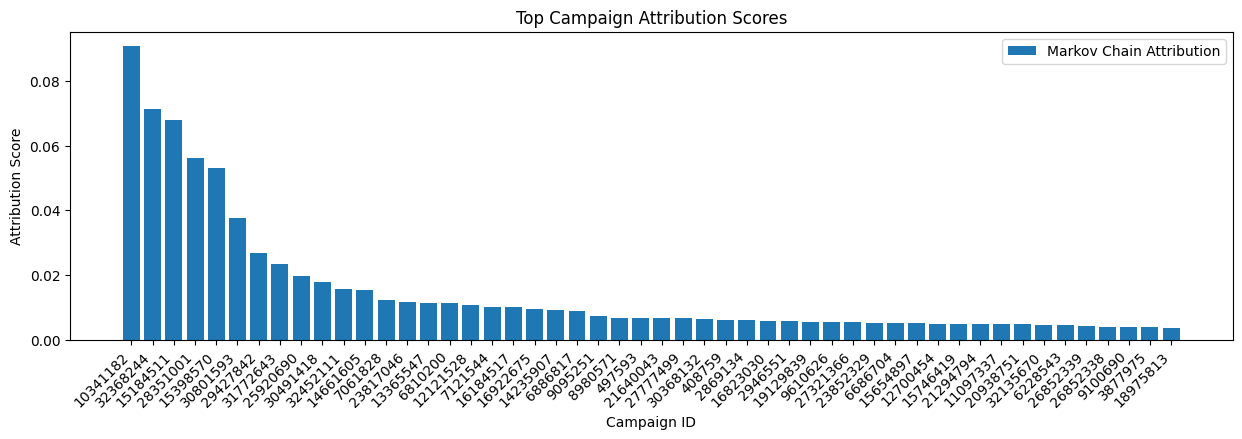

In [20]:
import matplotlib.pyplot as plt

# 假设 attribution_scores 是一个包含归因得分的 Pandas Series，索引为广告活动的唯一标识符
def plot_attribution_scores(attribution_scores, top_n=50):
    # 选择顶部 N 个广告活动进行展示
    top_campaigns = attribution_scores.sort_values(ascending=False).head(top_n)

    # 创建图形和轴对象
    fig, ax = plt.subplots(figsize=(15, 4))

    # 绘制条形图
    ax.bar(top_campaigns.index.astype(str), top_campaigns.values, label='Markov Chain Attribution')

    # 设置图形的标签和标题
    ax.set_ylabel('Attribution Score')
    ax.set_xlabel('Campaign ID')
    ax.set_title('Top Campaign Attribution Scores')
    ax.legend(loc='upper right')

    # 改善标签显示
    plt.xticks(rotation=45, ha='right')

    # 显示图形
    plt.show()

# 假设我们已经有了计算得到的 attribution_scores
plot_attribution_scores(attribution_scores)